In [1]:

import geopandas as gpd
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
import pandas as pd
import fiona

In [11]:
# Paths to vegetation data
veg_path = "jotrgeodata.gpkg"
veg_layer = "JOTR_VegPolys"


In [25]:
# Load vegetation data
veg = gpd.read_file(veg_path, layer=veg_layer)

# check coordinates reference system 
print(veg.crs)


EPSG:26911


For the purpose of this analysis, we reprojected the fire severity raster into NAD83 / UTM zone 11N to match the vegetation map, which may introduce some imprecision of sentinel 2 cells


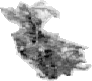

In [95]:
import folium
from branca.element import Figure

# Create a figure with controlled width
fig = Figure(width="800px", height="500px")

# Create folium map
m = folium.Map(
    location=center,
    zoom_start=12,
    tiles="OpenStreetMap"
)

# Add map to the figure
fig.add_child(m)

# Add overlay
folium.raster_layers.ImageOverlay(
    name="Refined RBR",
    image="rbr_overlay.png",
    bounds=img_bounds,
    opacity=1,
    interactive=True,
    cross_origin=False,
    zindex=1
).add_to(m)

folium.LayerControl().add_to(m)

# Show
fig


In [16]:
#Reproject raster into UTM zone 11N to match veg data
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS

# Input and output paths
raw_raster_path = "refined_rbr.tif"
raster_path = "refined_rbr_26911.tif"

# Define target CRS directly (EPSG:26911 = NAD83 / UTM Zone 11N)
target_crs = CRS.from_epsg(26911)

with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds
    )

    kwargs = src.meta.copy()
    kwargs.update({
        "crs": target_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    with rasterio.open(dst_path, "w", **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest
        )


In [18]:
#check the reprojected raster
with rasterio.open(raster_path) as src:
    print("Reprojected raster CRS:", src.crs)
    print("Reprojected raster bounds:", src.bounds)
    print("Reprojected raster shape:", src.shape)

Reprojected raster CRS: EPSG:26911
Reprojected raster bounds: BoundingBox(left=561417.5418511924, bottom=3768810.7052057004, right=562667.0048846161, top=3770443.3369027073)
Reprojected raster shape: (98, 75)


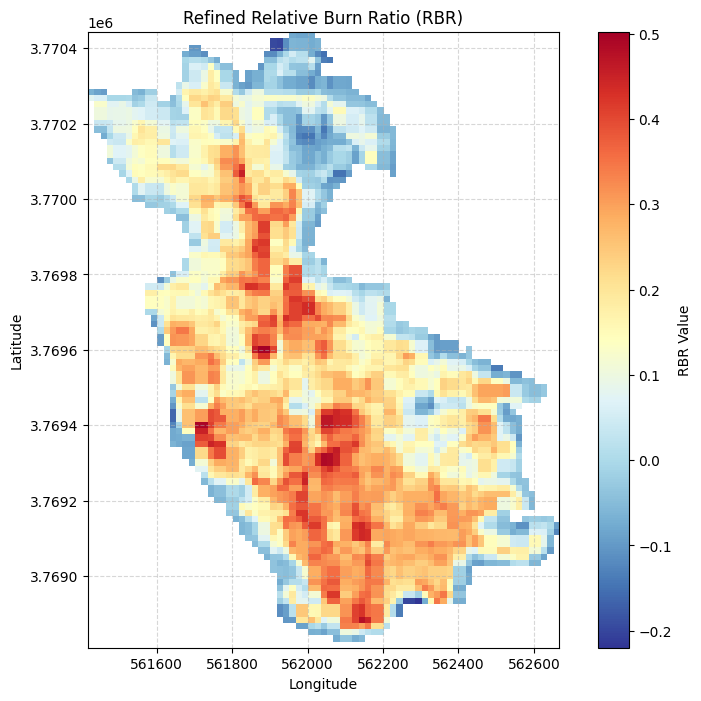

In [19]:
#Visualize fire severity

import rasterio
import matplotlib.pyplot as plt
import numpy as np

with rasterio.open(raster_path) as src:
    rbr = src.read(1)
    rbr[rbr == src.nodata] = np.nan
    bounds = src.bounds

# Plot with correct geographic extent
plt.figure(figsize=(10, 8))
plt.imshow(
    rbr,
    cmap="RdYlBu_r",
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
    origin="upper"
)
plt.colorbar(label="RBR Value")
plt.title("Refined Relative Burn Ratio (RBR)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [20]:
# Polygonize the raster to extract fire boundary
with rasterio.open(raster_path) as src:
    image = src.read(1)
    mask = image != src.nodata
    results = (
        {'properties': {'rbr': v}, 'geometry': s}
        for s, v in shapes(image, mask=mask, transform=src.transform)
        if v != 0
    )
    fire_polygons = gpd.GeoDataFrame.from_features(results, crs=src.crs)

In [21]:
# Merge into one polygon for fire boundary
fire_boundary = fire_polygons.union_all()  # use union_all, not unary_union
fire_boundary = gpd.GeoDataFrame(geometry=[fire_boundary], crs=fire_polygons.crs)

In [22]:
#export fire boundary to GeoPackage
fire_boundary.to_file("generated_fire_boundary_Eureka.gpkg", layer="fire_boundary", driver="GPKG")

In [27]:
# Clip vegetation polygons to fire boundary
clipped = gpd.overlay(veg, fire_boundary, how="intersection")

#check coordinate reference system
print(clipped.crs)

#check columns
print(clipped.columns)



EPSG:26911
Index(['Poly_ID', 'MapUnit_ID', 'MapUnit_Name', 'X_Centroid', 'Y_Centroid',
       'Acres', 'Hectares', 'SHAPE_Length', 'SHAPE_Area', 'geometry'],
      dtype='object')


In [28]:
import pandas as pd

# Calculate area in hectares (1 ha = 10,000 m²)
clipped["area_ha"] = clipped.geometry.area / 10_000

# Group by vegetation type and calculate total hectares
summary = clipped.groupby("MapUnit_Name").agg(
    veg_ha=("area_ha", "sum")
).reset_index()

# Compute total fire area
total_fire_area = summary["veg_ha"].sum()

# Add percent of total area per vegetation type
summary["pct_of_total"] = 100 * summary["veg_ha"] / total_fire_area

# Optional: Add total row to summary
total_row = pd.DataFrame({
    "MapUnit_Name": ["Total Burned Area"],
    "veg_ha": [total_fire_area],
    "pct_of_total": [100.0]
})

# Combine with main summary
summary = pd.concat([summary, total_row], ignore_index=True)

# Export to CSV
summary.to_csv("veg_burned_summary.csv", index=False)


In [29]:
# Join summary back to polygons
clipped = clipped.merge(summary, on="MapUnit_Name", how="left")

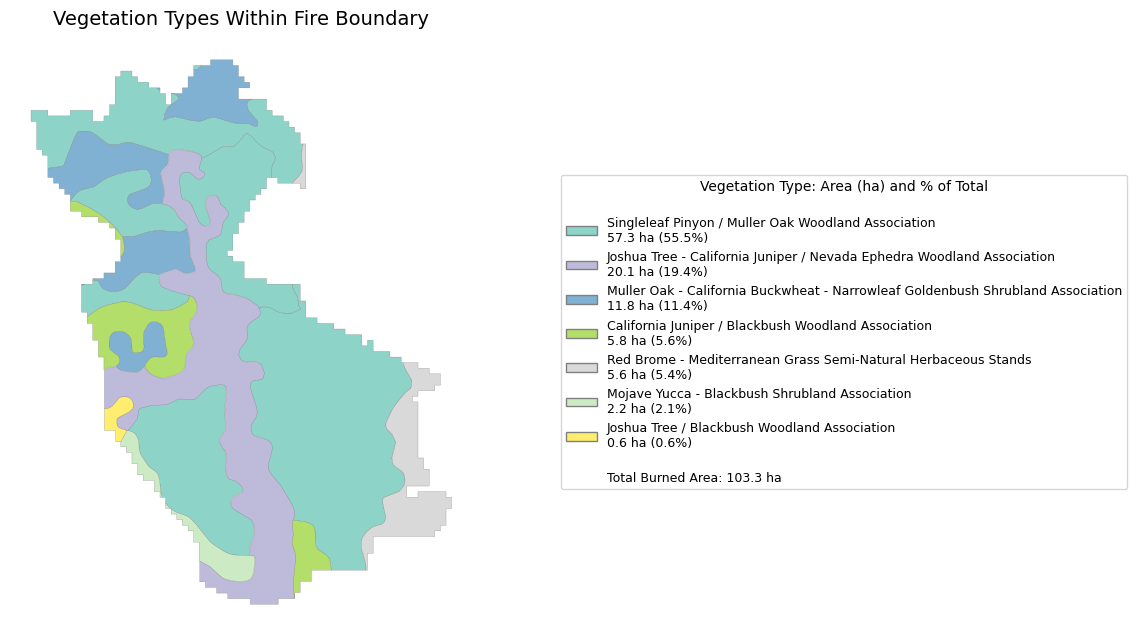

In [82]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Get summary of area by vegetation type
summary = clipped.groupby("MapUnit_Name").agg(
    area_ha=("area_ha", "sum")
).reset_index()
summary["pct_of_total"] = 100 * summary["area_ha"] / summary["area_ha"].sum()

# Sort by percent descending
summary = summary.sort_values(by="pct_of_total", ascending=False)
ordered_veg = summary["MapUnit_Name"].values

# Use updated colormap access (avoids deprecation warning)
base_cmap = plt.colormaps["Set3"]
color_list = base_cmap(np.linspace(0, 1, len(ordered_veg)))
colors = dict(zip(ordered_veg, color_list))

# Assign colors back to clipped
clipped["color"] = clipped["MapUnit_Name"].map(colors)

# Plot each vegetation type in order
fig, ax = plt.subplots(figsize=(10, 8))
for veg in ordered_veg:
    clipped[clipped["MapUnit_Name"] == veg].plot(
        ax=ax,
        color=colors[veg],
        edgecolor="gray",
        linewidth=0.2
    )

# Build legend entries
legend_patches = []
for veg in ordered_veg:
    row = summary[summary["MapUnit_Name"] == veg].iloc[0]
    label = f"{veg}\n{row['area_ha']:.1f} ha ({row['pct_of_total']:.1f}%)"
    patch = mpatches.Patch(facecolor=colors[veg], edgecolor='gray', label=label)
    legend_patches.append(patch)

# Add total burned area as final legend patch (invisible)
total_area = summary["area_ha"].sum()
total_label = f"\nTotal Burned Area: {total_area:.1f} ha"
total_patch = mpatches.Patch(facecolor='none', edgecolor='none', label=total_label)
legend_patches.append(total_patch)

# Add legend
ax.legend(
    handles=legend_patches,
    title="Vegetation Type: Area (ha) and % of Total\n",
    loc="center left",
    bbox_to_anchor=(1.15, 0.5),  # Move it further right to give more space
    fontsize=9,
    handlelength=2.5,            # Length of the color patch
    borderaxespad=1.5,           # Padding around legend content
    title_fontsize=10
)


ax.set_title("Vegetation Types Within Fire Boundary", fontsize=14, loc="center")
ax.axis("off")
plt.tight_layout()
plt.show()


In [83]:
#Load the full fire history layer
import geopandas as gpd

fire_hist = gpd.read_file("HistFires_JOTR_MOJA/FindExistingLocationsOutput.shp")

fire_hist = fire_hist.to_crs("EPSG:26911")

In [86]:
#Check coordinate systems
print(fire_hist.crs)
print(fire_boundary.crs)


EPSG:26911
PROJCS["NAD83 / UTM zone 11N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26911"]]


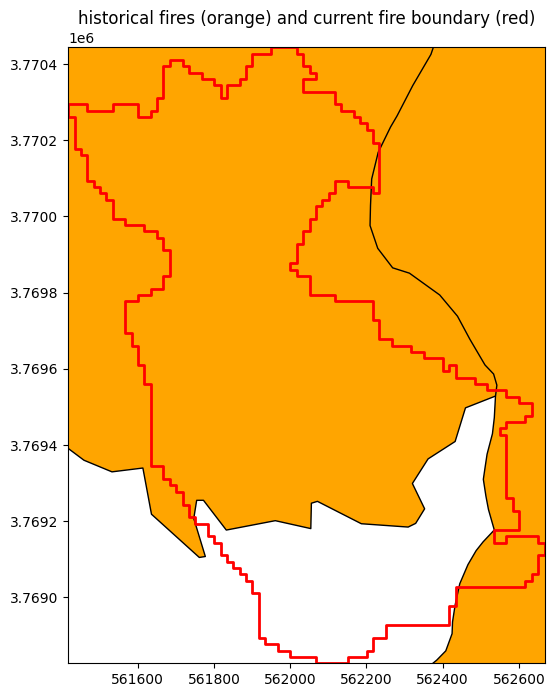

In [89]:
#Plot overlapping historical fires

fig, ax = plt.subplots(figsize=(10, 8))

# Plot all historical fires
fire_hist.plot(ax=ax, edgecolor="black", facecolor="orange", linewidth=1)

# Plot the fire boundary
fire_boundary.plot(ax=ax, edgecolor="red", facecolor= "none", linewidth=2)

# Zoom to fire boundary extent only
minx, miny, maxx, maxy = fire_boundary.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.title("historical fires (orange) and current fire boundary (red)")
plt.show()


In [91]:
#Spatial filter: which historical fires intersect the current fire boundary?
overlapping_fires = gpd.overlay(fire_hist, fire_boundary, how='intersection')
overlapping_fires[["FIRE_NAME", "YEAR_"]].drop_duplicates()

,FIRE_NAME,YEAR_
0,WHISPERING PINES,2006
1,COVINGTON,1995


In [92]:
#Filter to the one you want
whispering = overlapping_fires[overlapping_fires["FIRE_NAME"].str.upper() == "WHISPERING PINES"]

Processing complete. Outputs saved as 'veg_burned_output.gpkg' and 'veg_burned_summary.csv'.
